#  data 


In [2]:
import tensorflow as tf 
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Conv2DTranspose
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

**load the dataset**


In [3]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

**data normalization function**

In [4]:
def normalize(image , musk) : 
  image  = tf.cast(image , tf.float32) / 255.0
  musk -= 1  # we substact 1 becacuse the each pixel labels {1 ,2 ,3 } and we just made it {0,1,2}
  return image , musk

In [5]:
def prepare_data(split) : 
  image = tf.image.resize(split['image'] , (128 , 128)) 
  image_musk = tf.image.resize(split['segmentation_mask'] , (128,128))
  image , musk = normalize(image , image_musk)
  return image , musk

In [6]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH // BATCH_SIZE

In [7]:
train_data = dataset['train'].map(prepare_data , num_parallel_calls=tf.data.AUTOTUNE )
test_data = dataset['test'].map(prepare_data ,num_parallel_calls=tf.data.AUTOTUNE )

**data augmentation** 

In [8]:
class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42):
    super().__init__()
    self.augment_inputs = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed) 
    self.augment_labels = tf.keras.layers.RandomFlip(mode="horizontal", seed=seed)

  def call(self, inputs, labels):
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

**batch and shuffle the data**

In [9]:
train_batches = (train_data.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat().map(Augment()).prefetch(buffer_size=tf.data.AUTOTUNE))
test_batches = test_data.batch(BATCH_SIZE)

**visualize images and thier musks**

In [10]:

def display_image(display_list) : 
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

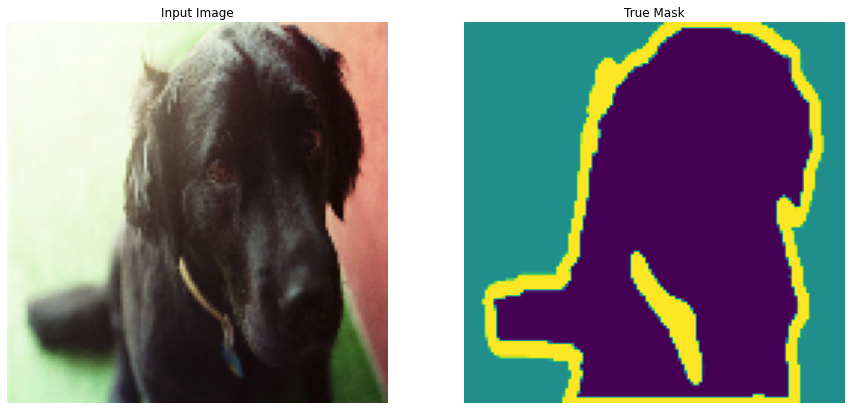

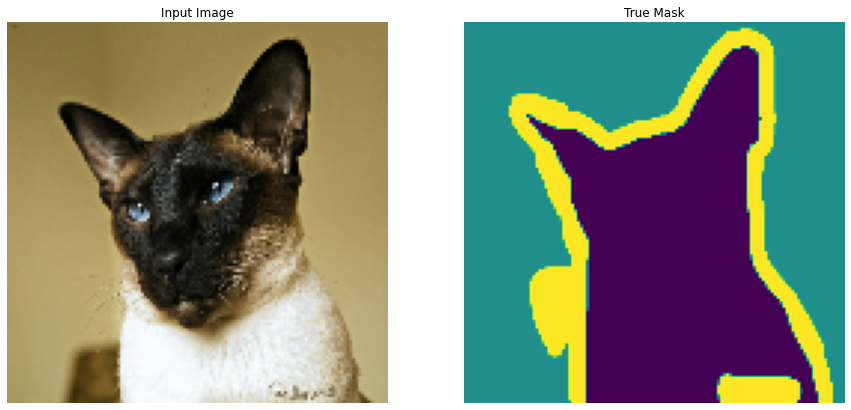

In [11]:
for images, masks in train_batches.take(2):
  sample_image, sample_mask = images[0], masks[0]
  display_image([sample_image, sample_mask])

# the model 

**conv block class**
which contain 

* 2 conv_layers 
* and optinal pooling layer 



In [12]:
class conv_block(tf.keras.Model) : 
  def __init__(self , n_filters) :
    super(conv_block , self).__init__()
    self.conv_1 = Conv2D(n_filters , (3,3) , padding='same' , activation ='relu')
    self.conv_2 = Conv2D(n_filters , (3,3) , padding='same' , activation ='relu')
    self.pooling = MaxPooling2D((2,2)) 
  def call(self , inputs , max_pooling = True ): 
    X = self.conv_1(inputs) 
    X_2 = self.conv_2(X)
    if max_pooling : 
      pool = self.pooling(X_2)
      return  pool , X_2 # we return X_2 to use it as connection skip to the decoder
    else : 
      return X_2

**the encoder** 
this encoder contain 
* four conv blocks 
* conv block without pooling layer as the bottle neck

we return last output and skip connection  

In [13]:
class down_sample(tf.keras.Model) : 
  def __init__(self): 
    super(down_sample,self).__init__()
    self.block1 = conv_block(64) # 64 
    self.block2 = conv_block(128) # 32 
    self.block3 = conv_block(256) # 16 
    self.block4 = conv_block(512) # 8 
    self.bottle_neck = conv_block(1024 )
  def call(self , inputs) : 
    X , skip_1= self.block1(inputs) 
    X , skip_2 = self.block2(X)
    X , skip_3 = self.block3(X)
    X , skip_4 = self.block4(X)
    X   = self.bottle_neck(X , max_pooling =False)
    return ( X ,skip_1, skip_2 ,skip_3 , skip_4)



**up sample block**

*  this contain conv_transpose layer whick take the last out put and up sample it

*  concat layer to concat the up sampled input and the skip connection 

*  conv_block without pooling  

In [14]:
class conv_transpose_block(tf.keras.Model): 
  def __init__(self , n_filters) : 
    super(conv_transpose_block , self).__init__()
    self.conv_t1 = Conv2DTranspose(n_filters , (3,3) , strides=(2,2) , activation='relu' , padding ='same')
    self.concat = tf.keras.layers.Concatenate()
    self.conv_block = conv_block(n_filters)
  def call(self, inputs ) : 
    previous_out , skip_connection = inputs 
    X = self.conv_t1(previous_out)
    X = self.concat([X , skip_connection])
    X = self.conv_block(X, max_pooling =False)
    return X 


**the decoder** 

it is contain four conv_transpose blocks 

In [15]:
class up_sample(tf.keras.Model) : 
  def __init__(self) : 
    super(up_sample,self).__init__()
    self.conv_transpose_1 = conv_transpose_block(512) 
    self.conv_transpose_2 = conv_transpose_block(256)
    self.conv_transpose_3 = conv_transpose_block(128)
    self.conv_transpose_4 = conv_transpose_block(64)
  def call(self , inputs) : 
    pool , skip_1, skip_2 ,skip_3 , skip_4 = inputs 
    X = self.conv_transpose_1((pool , skip_4))
    X = self.conv_transpose_2((X , skip_3))
    X = self.conv_transpose_3((X, skip_2)) 
    X = self.conv_transpose_4((X , skip_1))
    return X 

**the model**

we add the encoder and decoder after that we add output layer  

In [16]:
class U_net(tf.keras.Model): 
  def __init__(self ,n_channels): 
    super(U_net , self).__init__()
    self.down_sample = down_sample()
    self.up_sample = up_sample()
    self.outputs = Conv2D(n_channels , (1, 1) ,padding='same' , activation='softmax' )
  def call(self, inputs ):
    pool , skip_1 , skip_2 ,skip_3 , skip_4 = self.down_sample(inputs)
    X = self.up_sample((pool , skip_1 , skip_2 ,skip_3 , skip_4))
    X =  self.outputs(X)
    return X 

**initialize the model and compile it**

In [17]:
model = U_net(3)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# train the model

In [18]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [19]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display_image([image[0], mask[0], create_mask(pred_mask)])
  else:
    display_image([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

In [ ]:
show_predictions()

In [ ]:
from IPython.display import clear_output
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
EPOCHS = 20
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples//BATCH_SIZE//VAL_SUBSPLITS

model_history = model.fit(train_batches, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_batches,
                          callbacks=[DisplayCallback()])

In [ ]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

plt.figure()
plt.plot(model_history.epoch, loss, 'r', label='Training loss')
plt.plot(model_history.epoch, val_loss, 'bo', label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss Value')
plt.ylim([0, 1])
plt.legend()
plt.show()


In [ ]:

show_predictions(test_batches, 3)